# Experiment: Piecewise-linear approximation of VNF-PPs (Analysis)

Try to represent VNF-PPs as piece-wise linear functions.
The fitting is done using the [pwlf Python library](https://pypi.org/project/pwlf/).

Cite PWLF:

```latex
@Manual{pwlf,
    author = {Jekel, Charles F. and Venter, Gerhard},
    title = {{pwlf:} A Python Library for Fitting 1D Continuous Piecewise Linear Functions},
    year = {2019},
    url = {https://github.com/cjekel/piecewise_linear_fit_py}
}
```

## Segment number optimization

* Bayesian Optimization using [GPyOpt](https://sheffieldml.github.io/GPyOpt/)

```
@Misc{gpyopt2016,
  author =   {The GPyOpt authors},
  title =    {GPyOpt: A Bayesian Optimization framework in Python},
  howpublished = {\url{http://github.com/SheffieldML/GPyOpt}},
  year = {2016}
}
```

In [26]:
# basics
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np
import random
random.seed(12121)
np.random.seed(12121)
import pwlf
from sklearn import metrics as em
from GPyOpt.methods import BayesianOptimization

## Data Management
Load and clean the data sets to be easily used.

### Load data sets

In [8]:
def select_and_rename(df, mapping):
    """
    Helper: Selects columns of df using the keys
    of the mapping dict.
    It renames the columns to the values of the
    mappings dict.
    """
    # select subset of columns
    dff = df[list(mapping.keys())]
    # rename 
    for k, v in mapping.items():
        #print("Renaming: {} -> {}".format(k, v))
        dff.rename(columns={k: v}, inplace=True)
    #print(dff.head())
    return dff

def cleanup(df):
    """
    Cleanup of df data.
    Dataset specific.
    """
    def _replace(df, column, str1, str2):
        if column in df:
            df[column] = df[column].str.replace(str1, str2)
            
    def _to_num(df, column):
        if column in df:
            df[column] = pd.to_numeric(df[column])
        
    _replace(df, "flow_size", "tcpreplay -i data -tK --loop 40000 --preload-pcap /pcaps/smallFlows.pcap", "0")   
    _replace(df, "flow_size", "tcpreplay -i data -tK --loop 40000 --preload-pcap /pcaps/bigFlows.pcap", "1")
    _to_num(df, "flow_size")
    _replace(df, "ruleset", "./start.sh small_ruleset", "1")
    _replace(df, "ruleset", "./start.sh big_ruleset", "2")
    _replace(df, "ruleset", "./start.sh", "0")
    _to_num(df, "ruleset")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i http://20.0.0.254:8888/", "0")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k http://20.0.0.254:8888/bunny.mp4", "1")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i -X 20.0.0.254:3128 http://40.0.0.254:80/", "0")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -X 20.0.0.254:3128 http://40.0.0.254:80/bunny.mp4", "1")
    _to_num(df, "req_size")
    _replace(df, "req_type", "malaria publish -t -n 20000 -H 20.0.0.254 -q 1 --json /tngbench_share/malaria.json", "0")
    _replace(df, "req_type", "malaria publish -t -n 20000 -H 20.0.0.254 -q 2 --json /tngbench_share/malaria.json", "1")
    _replace(df, "req_type", "malaria publish -s 10 -n 20000 -H 20.0.0.254 --json /tngbench_share/malaria.json", "2")
    _replace(df, "req_type", "malaria publish -s 10000 -n 20000 -H 20.0.0.254 --json /tngbench_share/malaria.json", "3")
    _to_num(df, "req_type")
    
df_sec01 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_sec01/data/csv_experiments.csv")
df_sec02 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_sec02/data/csv_experiments.csv")
df_sec03 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_sec03/data/csv_experiments.csv")
df_web01 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_web01/data/csv_experiments.csv")
df_web02 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_web02/data/csv_experiments.csv")
df_web03 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_web03/data/csv_experiments.csv")
df_iot01 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_iot01/data/csv_experiments.csv")
df_iot02 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_iot02/data/csv_experiments.csv")

# do renaming and selection
map_sec01 = {
    "param__func__mp.input__cmd_start": "flow_size",
    "param__func__de.upb.ids-suricata.0.1__cmd_start": "ruleset",
    "param__func__de.upb.ids-suricata.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.ids-suricata.0.1__mem_max": "memory",
    "metric__vnf0.vdu01.0__suricata_bytes": "ids_bytes",
    "metric__vnf0.vdu01.0__suricata_packets": "ids_pkts",
    "metric__vnf0.vdu01.0__suricata_dropped": "ids_drop",
    #"metric__vnf0.vdu01.0__suricata_drops": "ids_drops",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    #"metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_in_tx_byte",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_sec02 = {
    "param__func__mp.input__cmd_start": "flow_size",
    "param__func__de.upb.ids-snort2.0.1__cmd_start": "ruleset",
    "param__func__de.upb.ids-snort2.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.ids-snort2.0.1__mem_max": "memory",
    "metric__vnf0.vdu01.0__snort_bytes": "ids_bytes",
    "metric__vnf0.vdu01.0__snort_packets": "ids_pkts",
    "metric__vnf0.vdu01.0__snort_dropped": "ids_drop",
    #"metric__vnf0.vdu01.0__snort_drops": "ids_drops",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    #"metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_in_tx_byte",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_sec03 = {
    "param__func__mp.input__cmd_start": "flow_size",
    "param__func__de.upb.ids-snort3.0.1__cmd_start": "ruleset",
    "param__func__de.upb.ids-snort3.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.ids-snort3.0.1__mem_max": "memory",
    #"metric__vnf0.vdu01.0__snort3_total_allow": "ids_allow",
    "metric__vnf0.vdu01.0__snort3_total_analyzed": "ids_pkts",
    "metric__vnf0.vdu01.0__snort3_total_received": "ids_recv",
    #"metric__vnf0.vdu01.0__snort3_total_outstanding": "ids_outstanding",
    "metric__vnf0.vdu01.0__snort3_total_dropped": "ids_drop",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    #"metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_in_tx_byte",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_web01 = {
    "param__func__mp.input__cmd_start": "req_size",
    "param__func__de.upb.lb-nginx.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.lb-nginx.0.1__mem_max": "memory",
    "metric__mp.input.vdu01.0__ab_completed_requests": "req_compl",
    #"metric__mp.input.vdu01.0__ab_concurrent_lvl": "req_concurrent",
    #"metric__mp.input.vdu01.0__ab_failed_requests": "req_failed",
    #"metric__mp.input.vdu01.0__ab_html_transfer_byte": "req_html_bytes",
    #"metric__mp.input.vdu01.0__ab_mean_time_per_request": "req_time_mean",
    "metric__mp.input.vdu01.0__ab_request_per_second": "req_per_sec",
    #"metric__mp.input.vdu01.0__ab_time_used_s": "req_time_used",
    "metric__mp.input.vdu01.0__ab_total_transfer_byte": "transf_bytes",
    #"metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "req_transf_rate",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_web02 = {
    "param__func__mp.input__cmd_start": "req_size",
    "param__func__de.upb.lb-haproxy.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.lb-haproxy.0.1__mem_max": "memory",
    "metric__mp.input.vdu01.0__ab_completed_requests": "req_compl",
    #"metric__mp.input.vdu01.0__ab_concurrent_lvl": "req_concurrent",
    #"metric__mp.input.vdu01.0__ab_failed_requests": "req_failed",
    #"metric__mp.input.vdu01.0__ab_html_transfer_byte": "req_html_bytes",
    #"metric__mp.input.vdu01.0__ab_mean_time_per_request": "req_time_mean",
    "metric__mp.input.vdu01.0__ab_request_per_second": "req_per_sec",
    #"metric__mp.input.vdu01.0__ab_time_used_s": "req_time_used",
    "metric__mp.input.vdu01.0__ab_total_transfer_byte": "transf_bytes",
    #"metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "req_transf_rate",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_web03 = {
    "param__func__mp.input__cmd_start": "req_size",
    "param__func__de.upb.px-squid.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.px-squid.0.1__mem_max": "memory",
    "metric__mp.input.vdu01.0__ab_completed_requests": "req_compl",
    #"metric__mp.input.vdu01.0__ab_concurrent_lvl": "req_concurrent",
    #"metric__mp.input.vdu01.0__ab_failed_requests": "req_failed",
    #"metric__mp.input.vdu01.0__ab_html_transfer_byte": "req_html_bytes",
    #"metric__mp.input.vdu01.0__ab_mean_time_per_request": "req_time_mean",
    "metric__mp.input.vdu01.0__ab_request_per_second": "req_per_sec",
    #"metric__mp.input.vdu01.0__ab_time_used_s": "req_time_used",
    "metric__mp.input.vdu01.0__ab_total_transfer_byte": "transf_bytes",
    #"metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "req_transf_rate",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_iot01 = {
    "param__func__mp.input__cmd_start": "req_type",
    "param__func__de.upb.broker-mosquitto.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.broker-mosquitto.0.1__mem_max": "memory",
    #"metric__mp.input.vdu01.0__malaria_clientid": "mal_id",
    #"metric__mp.input.vdu01.0__malaria_count_ok": "mal_count_ok",
    #"metric__mp.input.vdu01.0__malaria_count_total": "mal_count_total",
    "metric__mp.input.vdu01.0__malaria_msgs_per_sec": "msg_per_sec",
    #"metric__mp.input.vdu01.0__malaria_rate_ok": "mal_rate_ok",
    #"metric__mp.input.vdu01.0__malaria_time_max": "mal_time_max",
    "metric__mp.input.vdu01.0__malaria_time_mean": "msg_t_mean",
    #"metric__mp.input.vdu01.0__malaria_time_min": "mal_time_min",
    "metric__mp.input.vdu01.0__malaria_time_stddev": "msg_t_std",
    #"metric__mp.input.vdu01.0__malaria_time_total": "mal_time_total",
    #"metric__mp.output.vdu01.0__malaria_client_count": "mal_ccount",
    #"metric__mp.output.vdu01.0__malaria_clientid": "mal_cid2",
    #"metric__mp.output.vdu01.0__malaria_flight_time_max": "mal_ft_max",
    #"metric__mp.output.vdu01.0__malaria_flight_time_mean": "mal_ft_mean",
    #"metric__mp.output.vdu01.0__malaria_flight_time_min": "mal_ft_min",
    #"metric__mp.output.vdu01.0__malaria_flight_time_stddev": "mal_ft_stddev",
    #"metric__mp.output.vdu01.0__malaria_ms_per_msg": "mal_ms_per_msg",
    #"metric__mp.output.vdu01.0__malaria_msg_count": "mal_out_msg_count",
    #"metric__mp.output.vdu01.0__malaria_msg_duplicates": "mal_out_msg_dup",
    #"metric__mp.output.vdu01.0__malaria_msg_per_sec": "mal_out_msgs_per_sec",
    #"metric__mp.output.vdu01.0__malaria_test_complete": "mal_test_complete",
    #"metric__mp.output.vdu01.0__malaria_time_total": "mal_out_t_total",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_iot02 = {
    "param__func__mp.input__cmd_start": "req_type",
    "param__func__de.upb.broker-emqx.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.broker-emqx.0.1__mem_max": "memory",
    #"metric__mp.input.vdu01.0__malaria_clientid": "mal_id",
    #"metric__mp.input.vdu01.0__malaria_count_ok": "mal_count_ok",
    #"metric__mp.input.vdu01.0__malaria_count_total": "mal_count_total",
    "metric__mp.input.vdu01.0__malaria_msgs_per_sec": "msg_per_sec",
    #"metric__mp.input.vdu01.0__malaria_rate_ok": "mal_rate_ok",
    #"metric__mp.input.vdu01.0__malaria_time_max": "mal_time_max",
    "metric__mp.input.vdu01.0__malaria_time_mean": "msg_t_mean",
    #"metric__mp.input.vdu01.0__malaria_time_min": "mal_time_min",
    "metric__mp.input.vdu01.0__malaria_time_stddev": "msg_t_std",
    #"metric__mp.input.vdu01.0__malaria_time_total": "mal_time_total",
    #"metric__mp.output.vdu01.0__malaria_client_count": "mal_ccount",
    #"metric__mp.output.vdu01.0__malaria_clientid": "mal_cid2",
    #"metric__mp.output.vdu01.0__malaria_flight_time_max": "mal_ft_max",
    #"metric__mp.output.vdu01.0__malaria_flight_time_mean": "mal_ft_mean",
    #"metric__mp.output.vdu01.0__malaria_flight_time_min": "mal_ft_min",
    #"metric__mp.output.vdu01.0__malaria_flight_time_stddev": "mal_ft_stddev",
    #"metric__mp.output.vdu01.0__malaria_ms_per_msg": "mal_ms_per_msg",
    #"metric__mp.output.vdu01.0__malaria_msg_count": "mal_out_msg_count",
    #"metric__mp.output.vdu01.0__malaria_msg_duplicates": "mal_out_msg_dup",
    #"metric__mp.output.vdu01.0__malaria_msg_per_sec": "mal_out_msgs_per_sec",
    #"metric__mp.output.vdu01.0__malaria_test_complete": "mal_test_complete",
    #"metric__mp.output.vdu01.0__malaria_time_total": "mal_out_t_total",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
    

}

# add additional data
df_sec01["vnf"] = "suricata"
df_sec02["vnf"] = "snort2"
df_sec03["vnf"] = "snort3"
df_web01["vnf"] = "nginx"
df_web02["vnf"] = "haproxy"
df_web03["vnf"] = "squid"
df_iot01["vnf"] = "mosquitto"
df_iot02["vnf"] = "emqx"


# cleanup data sets
dfs_raw = [df_sec01, df_sec02, df_sec03, df_web01, df_web02, df_web03, df_iot01, df_iot02]
map_list = [map_sec01, map_sec02, map_sec03, map_web01, map_web02, map_web03, map_iot01, map_iot02]
dfs = list()  # clean data frames

for (df, m) in zip(dfs_raw, map_list):
    tmp = select_and_rename(df.copy(), m)
    cleanup(tmp)
    dfs.append(tmp)

In [9]:
dfs[3].head()

,req_size,cpu_bw,memory,req_compl,req_per_sec,transf_bytes,if_rx_bytes,if_tx_bytes
0,0,0.1,64,104196.0,1733.25,31838613.0,18412200.0,39004587.0
1,0,0.1,64,105190.0,1747.06,32142337.0,18587678.0,39376437.0
2,0,0.1,64,103188.0,1710.96,31530605.0,18233626.0,38627397.0
3,0,0.1,64,103718.0,1717.78,31692564.0,18327338.0,38825497.0
4,0,0.1,64,100496.0,1656.68,30707997.0,17758410.0,37619913.0


### Polish data

In [10]:
#df = dfs[0].copy()
#df = df[(df["flow_size"]==0) & (df["ruleset"]==2) & (df["memory"]==256)]
#df = df.groupby("cpu_bw").mean()
#df.head()
#dfs[1][dfs[1]["ids_pkts"].isnull()]

## PWLF Prototype

More advanced PWLF implementation to be used with generic data sets.

In [78]:
class MyPWLF(object):
    """
    Wrapper around PWLF to also fit functions with only one
    segment by using a trick that creates a first segment that is
    virtually 0.
    """
    def __init__(self, data, x_col, y_col, degree=1):
        # ensure we work on fresh data
        data = data.copy()
        # ensure that we drop the NaN from the data
        data.dropna(subset=[x_col, y_col], inplace=True)
        # get the data
        self.xin = np.array(data[x_col])
        self.yin = np.array(data[y_col])
        assert(len(self.xin) == len(self.yin))
        # PWLF Model
        self.pwlf_obj = pwlf.PiecewiseLinFit(self.xin, self.yin, degree=degree)       
        
    def fit(self, nseg, fast=True):
        if nseg < 2:
            # Workaround: fit(1) does not work, so we do it by specifing the breakpoints manually
            x0 = np.array([min(self.xin), max(self.xin)])
            self.pwlf_obj.fit_with_breaks(x0)
        else:
            # do normal PWLF fit
            if not fast:
                x0 = self.pwlf_obj.fit(nseg)
            else:
                x0 = self.pwlf_obj.fitfast(nseg, pop=50)
        
        # calc additional error metrics    
        self.err_mse = em.mean_squared_error(self.yin, self.predict(self.xin))
        self.err_mae = em.mean_absolute_error(self.yin, self.predict(self.xin))
        self.err_r2 = em.r2_score(self.yin, self.predict(self.xin))
        self.err_evs = em.explained_variance_score(self.yin, self.predict(self.xin))
        # return breakpoints
        return x0[1:-1]
    
    def predict(self, x):
        return self.pwlf_obj.predict(x)

def plot_pwlf(mpf, x, y, ax=None, x_bpoints=None, points=True, pointargs=None, lineargs=None):
    assert(ax is not None)
    if pointargs is None:
        pointargs = {}
    if lineargs is None:
        lineargs = {}
    xHat = np.linspace(min(x), max(x), num=10000)
    yHat = mpf.predict(xHat)
    
    # plot data points
    if points:
        ax.plot(x, y, 'o', color="grey", fillstyle='none', **pointargs)
    # plot breakpoints
    if x_bpoints is not None:
        y_bpoints = mpf.predict(x_bpoints)
        label = "break pt." if points else None
        ax.plot(x_bpoints, y_bpoints, 'o', color="firebrick", markersize=7, label=label)
    # plot fit line
    ax.plot(xHat, yHat, **lineargs)
    return x, y, mpf    

## PWLF Segment No. Optimization

In [70]:
def find_opt_nseg(pwlf_obj, x, y, max_seg=16, max_iter=30, plot_enabled=True, penalty=1e-2):
    """
    Find optimal number of segments.
    Based on: https://jekel.me/piecewise_linear_fit_py/examples.html#find-the-best-number-of-line-segments
    """
    
    def f_obj(xd):
        f = np.zeros(xd.shape[0])
        for i, j in enumerate(xd):
            pwlf_obj.fit(j[0], fast=True)  # use the fast fitting version of PWLF
            #f[i] = 1.0 - pwlf_obj.err_r2 #- (penalty * j[0])
            f[i] = (pwlf_obj.err_mae/max(y)) + (j[0] * 0.005)
        print("Objective: {}".format(f))
        return f
    
    print("Running optimizer ...")
    
    # define the lower and upper bound for the number of line segments
    bounds = [{'name': 'nseg', 'type': 'discrete',
               'domain': np.arange(1, max_seg)}]

    bo = BayesianOptimization(f_obj, domain=bounds, model_type='GP',
                                  #initial_design_numdata=8,
                                  exact_feval=True, verbosity=True,
                                  verbosity_model=False)

    # perform the bayesian optimization
    bo.run_optimization(max_iter=max_iter, verbosity=True)

    print('Optimum number of line segments: {}'.format(bo.x_opt))
    print('Function value: {}'.format(bo.fx_opt))
    if plot_enabled:
        bo.plot_acquisition()
        bo.plot_convergence()
    return int(bo.x_opt)

## Analysis

In [89]:
def get_lstyle(label):
    if "(opt)" in label:
        # special case
        return {"color": "firebrick", "ls": 'solid', "lw": 2.0} 
    # normal case
    styles = [
        ('densely dashed',        (0, (5, 1))),
        ('dotted', 'dotted'),
        ('dashed', 'dashed'),
        ('dashdot', 'dashdot'),
        ('densely dotted',        (0, (1, 1))),
        ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),
        ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
    ]
    styles *= 4
    # colors
    l = int(label.replace("(opt)", "").strip()) - 1
    return {"color": "black", "ls": styles[l][1], "lw": 1.0}  

In [14]:
def select(data, sel_dict):
    """
    Select subset of data from DF.
    """
    for k, v in sel_dict.items():
        data = data[data[k]==v]
    return data

In [92]:
def analyse_fits(data, x_col, y_col, name="unnamed", x_label="x-axis", y_label="y-axis"):
    """
    - Shows fit with multiple lines (1-n segments + opt. segment (solid, bold)) in a single plot
    - Creates multiple plots for different degrees
    """
    MAX_SEG = 12
    PLOT_SEG = [1, 2, 3, 4]
    res_dicts = list()
    # iterate over different degrees (one plot per degree)
    for degree in [0, 1, 2]:
        print("PWLF degree={}".format(degree))
        # create a PWLF object and get raw input data
        mpf = MyPWLF(data, x_col, y_col, degree=degree)
        (x, y) = (mpf.xin, mpf.yin)
        
        # compute optimal number of segments (and add/mark it in the segments dict)
        segments = {str(i):i for i in range(1, MAX_SEG)}
        opt_nseg = find_opt_nseg(mpf, x, y, max_seg=MAX_SEG, max_iter=20, plot_enabled=False)
        if str(opt_nseg) in segments:
            del segments[str(opt_nseg)]  # remove if already exists          
        segments["{} (opt)".format(opt_nseg)] = opt_nseg
                
        # create figure
        matplotlib.rcParams.update({'font.size': 22})
        fig, ax = plt.subplots(1, 1, figsize=(9, 6))
        # analyse for different no. segments
        for label, nseg in segments.items():
            lineargs = {"label": "nseg={}".format(label)}
            lineargs.update(get_lstyle(label))
            
            # fit PWLF to the data
            breaks = mpf.fit(nseg)
            
            # plot some of the fits
            if nseg in PLOT_SEG or "opt" in label:
                plot_pwlf(mpf, x, y, ax=ax,
                          x_bpoints=breaks, # plot breakpoints
                          points=(nseg==1),  # ensure points are only plotted once
                          pointargs={"label": "data", "markersize": 12},
                          lineargs=lineargs                        
                         )
            print("PWLF fit: label={}, nseg={}, MAE={}, MSE={}, EVS={}, R^2={}".format(label, nseg, mpf.err_mae, mpf.err_mse, mpf.err_evs, mpf.err_r2))
            res_dicts.append({"name": name, "label": label, "nseg": nseg, "degree": degree, "mae": mpf.err_mae, "mse": mpf.err_mse, "evs": mpf.err_evs, "r2": mpf.err_r2})
        # finalize plot
        ax.set_ylim(min(0.0, min(y)), np.max(y)*1.1)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.legend(fancybox=False, shadow=False, fontsize="small")
        plt.savefig("plots/analysis_fits-opt-_deg-{}_{}_{}_{}.pdf".format(degree, x_col, y_col, name), dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()
    # return DF with error metrics for further plots
    return pd.DataFrame(res_dicts)
        
        

In [95]:
def analyse_errors(data):
    """
    Bar plots with error values.
    Input: DF that was returmed by analyse_fit()
    """
    x_col = "degree"
    y_cols = ["mae", "mse", "evs", "r2"]
    y_labels = {"mae": "MAE", "mse": "MSE", "evs": "EVS", "r2": "$R^2$"}
    hue = "nseg"
    matplotlib.rcParams.update({'font.size': 22})
    name = list(set(list(data["name"])))[0]
    
    for y_col in y_cols:
        fig, ax = plt.subplots(1, 1, figsize=(9, 6))
        sns.barplot(ax=ax, x=x_col, y=y_col, hue=hue, data=data, palette=sns.color_palette("Reds_d", 12), linewidth=3, saturation=.9, edgecolor=(1,1,1))
        if y_col == "mse":
            ax.set_yscale('log')
        y_lim_min = 0.0
        if y_col == "r2" or y_col == "evs":
            y_lim_min = data[y_col].min() - 0.1
        if y_col != "mse":
            ax.set_ylim(y_lim_min, data[y_col].max() * 1.1)
        
        ax.set_xlabel("Degree")
        ax.set_ylabel(y_labels[y_col])
        ax.legend(fancybox=False, shadow=False, fontsize="small", ncol=2, title="Segments", loc="upper right")
        plt.savefig("plots/error-opt-{}-{}.pdf".format(name, y_col), dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()

### Fit Analysis of Data Sets

PWLF degree=0
Running optimizer ...
Objective: [0.08048364]
Objective: [0.07606408]
Objective: [0.0692826]
Objective: [0.07401534]
Objective: [0.06726583]
Objective: [0.07385687]
num acquisition: 1, time elapsed: 0.47s
Objective: [0.07367948]
num acquisition: 2, time elapsed: 1.04s
Objective: [0.07423872]
num acquisition: 3, time elapsed: 1.48s
Objective: [0.21884976]
num acquisition: 4, time elapsed: 1.62s
Objective: [0.06619263]
num acquisition: 5, time elapsed: 2.13s
Objective: [0.09087721]
num acquisition: 6, time elapsed: 2.58s
Objective: [0.06885687]
num acquisition: 7, time elapsed: 3.03s
Objective: [0.06378913]
num acquisition: 8, time elapsed: 3.46s
Objective: [0.13762811]
num acquisition: 9, time elapsed: 3.77s
Objective: [0.07201963]
num acquisition: 10, time elapsed: 4.31s
Objective: [0.06952648]
num acquisition: 11, time elapsed: 4.77s
Objective: [0.06378913]
num acquisition: 12, time elapsed: 5.33s
Objective: [0.06371145]
num acquisition: 13, time elapsed: 5.75s
Optimum n

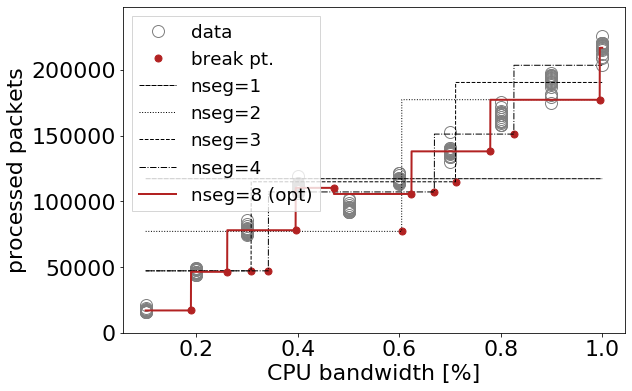

PWLF degree=1
Running optimizer ...
Objective: [0.0462617]
Objective: [0.05626037]
Objective: [0.05130265]
Objective: [0.0362457]
Objective: [0.02697868]
Objective: [0.04856278]
num acquisition: 1, time elapsed: 0.33s
Objective: [0.03141219]
num acquisition: 2, time elapsed: 1.66s
Objective: [0.06626037]
num acquisition: 3, time elapsed: 7.19s
Objective: [0.02697868]
num acquisition: 4, time elapsed: 8.64s
Objective: [0.02697868]
num acquisition: 5, time elapsed: 9.82s
Optimum number of line segments: [3.]
Function value: 0.026978681457294776
PWLF fit: label=1, nseg=1, MAE=9820.227831818178, MSE=134549859.76325107, EVS=0.9617039424635581, R^2=0.9617039424635581
PWLF fit: label=2, nseg=2, MAE=8374.829118206748, MSE=117082707.97173356, EVS=0.9666755050588869, R^2=0.9666755050588869
PWLF fit: label=4, nseg=4, MAE=2572.9130895227295, MSE=13704236.09424923, EVS=0.9960994517951799, R^2=0.9960994517951799
PWLF fit: label=5, nseg=5, MAE=2534.801726243401, MSE=13488648.721539984, EVS=0.99616081

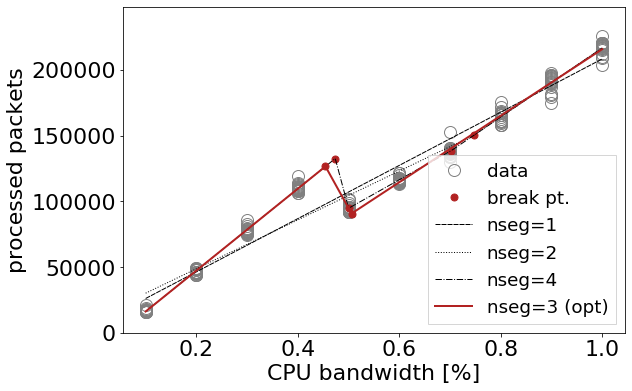

PWLF degree=2
Running optimizer ...
Objective: [0.06626037]
Objective: [0.05126037]
Objective: [0.02642704]
Objective: [0.06626037]
Objective: [0.05626037]
Objective: [0.0475951]
num acquisition: 1, time elapsed: 0.44s
Objective: [0.03124992]
num acquisition: 2, time elapsed: 2.09s
Objective: [0.04126037]
num acquisition: 3, time elapsed: 3.90s
Objective: [0.02642391]
num acquisition: 4, time elapsed: 5.21s
Objective: [0.02642391]
num acquisition: 5, time elapsed: 6.28s
Optimum number of line segments: [3.]
Function value: 0.026423911337922913
PWLF fit: label=1, nseg=1, MAE=9602.084921212108, MSE=133088534.89049351, EVS=0.9621198699234976, R^2=0.9621198699234976
PWLF fit: label=2, nseg=2, MAE=5175.372021183626, MSE=41645731.2890768, EVS=0.9881466444900058, R^2=0.9881466444900058
PWLF fit: label=4, nseg=4, MAE=2536.034799999789, MSE=13486547.292675013, EVS=0.9961614111527354, R^2=0.9961614111527354
PWLF fit: label=5, nseg=5, MAE=2545.3577280451814, MSE=13483716.366865652, EVS=0.99616223

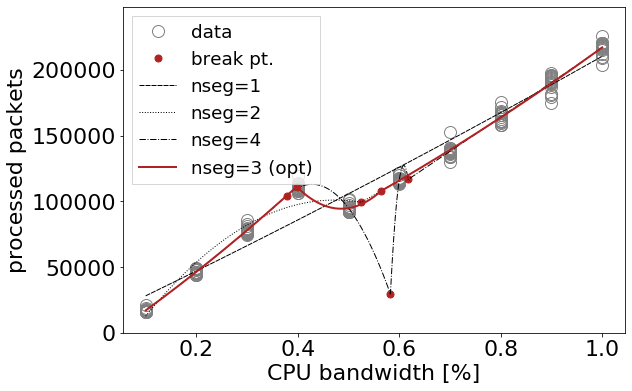

,degree,evs,label,mae,mse,name,nseg,r2
0,0,0.000000,1,48207.509375,3.513413e+09,ds-sec01,1,0.000000
1,0,0.684806,2,28770.821625,1.107407e+09,ds-sec01,2,0.684806
2,0,0.876694,3,17022.037875,4.332235e+08,ds-sec01,3,0.876694
3,0,0.916364,4,14038.217083,2.938494e+08,ds-sec01,4,0.916364
4,0,0.937748,5,12434.081000,2.187185e+08,ds-sec01,5,0.937748
5,0,0.958820,6,8496.588625,1.446816e+08,ds-sec01,6,0.958820
6,0,0.971353,7,7155.225917,1.006502e+08,ds-sec01,7,0.971353
7,0,0.986125,9,5362.712500,4.874688e+07,ds-sec01,9,0.986125
8,0,0.986360,10,4524.131500,4.792359e+07,ds-sec01,10,0.986360
9,0,0.986598,11,4283.050625,4.708607e+07,ds-sec01,11,0.986598


In [93]:
d = select(dfs[0].copy(), {"flow_size": 0, "ruleset": 2, "memory": 256})
df_err = analyse_fits(d, "cpu_bw", "ids_pkts", name="ds-sec01", x_label="CPU bandwidth [%]", y_label="processed packets")
df_err

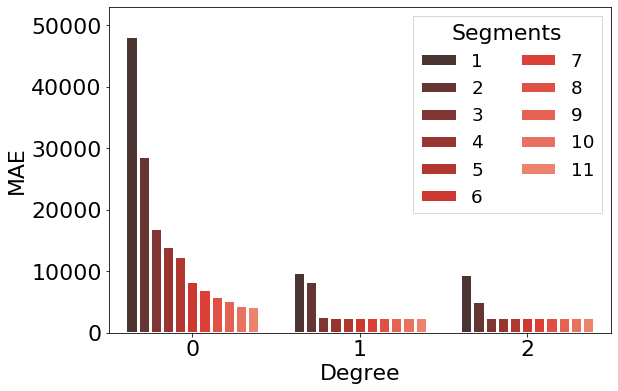

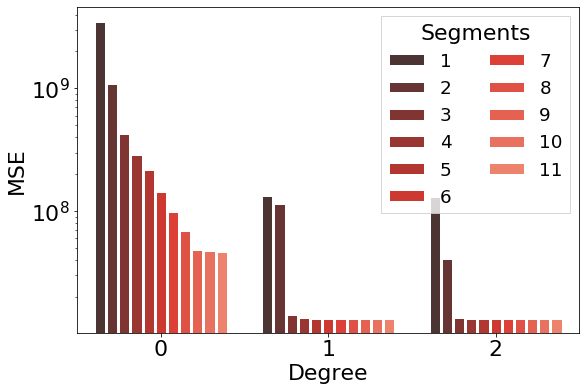

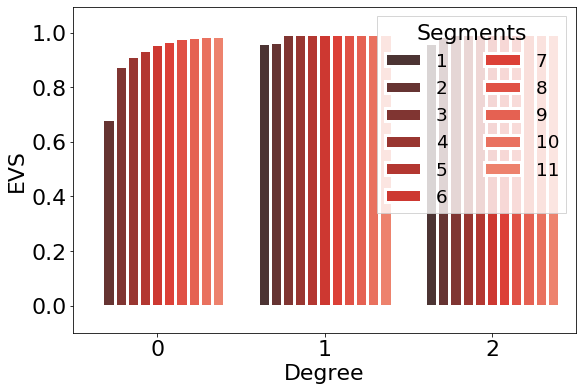

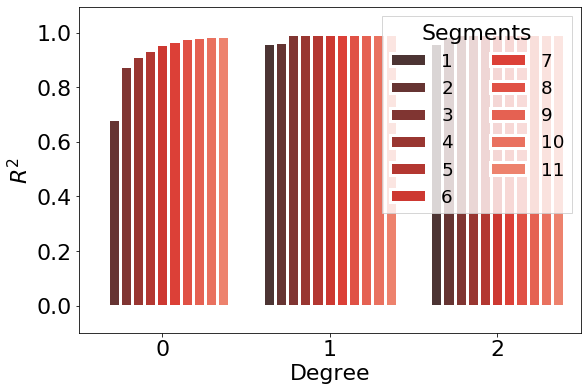

In [96]:
analyse_errors(df_err)

In [ ]:
d = select(dfs[1].copy(), {"flow_size": 0, "ruleset": 2, "memory": 256})
analyse_fits(d, "cpu_bw", "ids_pkts", name="ds-sec02", x_label="CPU bandwidth [%]", y_label="no. processed packets")

In [ ]:
d = select(dfs[2].copy(), {"flow_size": 0, "ruleset": 0, "memory": 256})
analyse_fits(d, "cpu_bw", "ids_pkts", name="ds-sec03", x_label="CPU bandwidth [%]", y_label="no. processed packets")